# Traveltime tomography using the Eikonal equation (2D case)

@Author: Ettore Biondi - ebiondi@caltech.edu


First create a conda env as:

`conda create --name Eikonal python==3.9`

Then run the notebook within that environment after the installation steps below.

Activate the conda env.

Import everything you'll need.

Download eikonal2d.py into the working directory by downloading it from Drive and uploading it in colab.

https://drive.google.com/file/d/1EtTudLCntiKnq2o3BxG5F7ouwxb1pRj-/view

## Computing the Sensitivity Kernels

### Loading All Necessary Packages 

In [26]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import numpy as np
import occamypy as o
import lib.eikonal2d as k
import torch
from lib.fno import *
from lib.datahelper import *
# Plotting
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

EikonalPath = "./Scripts/Eikonal3D/"
SolverPath = "./Scripts/Solver/"
import sys
import os
sys.path.append(EikonalPath)
sys.path.append(SolverPath)

import numpy as np

# Plotting
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
rcParams.update({
    'image.cmap'     : 'jet_r',
    'image.aspect'   : 'auto',
    'image.interpolation': 'none',
    'axes.grid'      : False,
    'figure.figsize' : (10, 6),
    'savefig.dpi'    : 300,
    'axes.labelsize' : 14,
    'axes.titlesize' : 16,
    'font.size'      : 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Choose Starting Velocity Field, FNO Model, and Source/Receiver Positions

In [27]:
dx = dz = 1
nx, nz = 100, 100
x = np.linspace(0,(nx-1)*dx, nx)
z = np.linspace(0,(nz-1)*dz, nz)

# Source/Receiver positions
SouPos = np.array([[int(nx/2), int(nz/2)]])
RecPos = np.array([[int(2*nx/5),ix] for ix in np.arange(int(nx/4),int(3*nx/4))])

# Starting Velocity Field
filename = 'DatVel30_Sou100_Rec100_Dim100x100_Downsampled.npz'
with np.load(filename, allow_pickle=True) as fid:
    train_data = EikonalDataset(fid, 'train')
x_train_vels = train_data.vels
vel_field = x_train_vels[0].cpu().detach().numpy()

# FNO Model
fno_model = torch.load('../FinalizedModels/mode-8-width-64-epoch-110', map_location=torch.device('cpu'))

### Set Up Variables

In [28]:
# Set up innitial velocity fields
vv = o.VectorNumpy(vel_field, ax_info=[o.AxInfo(nx, 0, dx, "x [km]"), o.AxInfo(nz, 0, dz, "z [km]")])

# Data vector
tt_data = o.VectorNumpy((SouPos.shape[0], RecPos.shape[0]))
tt_data.zero()

# Setting Eikonal Equation Solvers
Eik2D_Lin_Op = k.EikonalTT_lin_2D(vv, tt_data, SouPos, RecPos, fno_model)
Eik2D_Op = k.EikonalTT_2D(vv, tt_data, SouPos, RecPos, fno_model)
Eik2D_Op.forward(False, vv, tt_data)

# Travel-time residuals are all set to zero
tt_pert = tt_data.clone().set(1.0)


### Compute Sensitivity Kernel Using Adjoint of FMM

In [29]:
kernel2 = vv.clone()
Eik2D_Lin_Op.adjoint(False, kernel2, tt_pert, True)

Using Adjoint of FMM to Compute Sensitivity Kernels...


### Plot Kernel from Adjoint of FMM

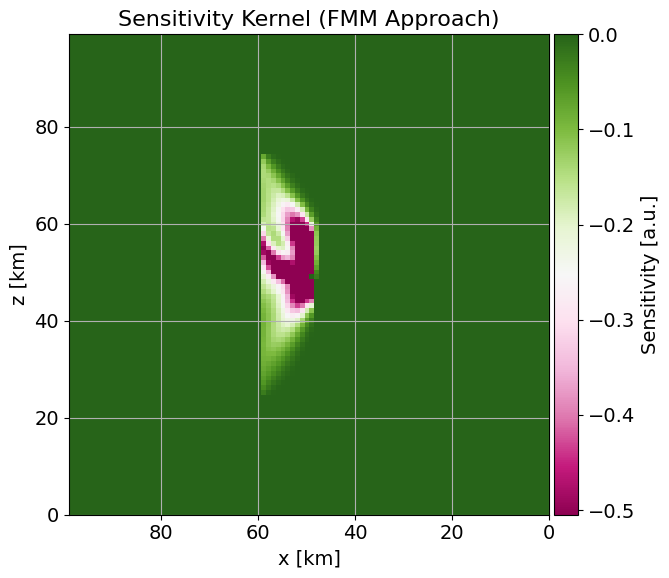

In [30]:
fig, ax = plt.subplots()
im = ax.imshow(kernel2.plot().T, extent=[z[-1], z[0], x[0], x[-1] ], aspect='equal', cmap=plt.get_cmap("PiYG"), vmin=kernel2.min()*0.1, vmax=kernel2.max())
ax = plt.gca()
ax.grid()
plt.xlabel(kernel2.ax_info[0].l)
plt.ylabel(kernel2.ax_info[1].l)
plt.title("Sensitivity Kernel (FMM Approach)")

cbar = plt.colorbar(im, orientation="vertical",
                    cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))
cbar.set_label('Sensitivity [a.u.]')
plt.tight_layout()
plt.show()
kernel_fmm = kernel2.plot().T

### Compute Sensivity Kernel Using FNO Model

In [31]:
kernel = vv.clone()
Eik2D_Lin_Op.adjoint(False, kernel, tt_pert, False)

Using FNO Model to Compute Sensitivity Kernels...


### Plot Kernel from FNO Model Inference

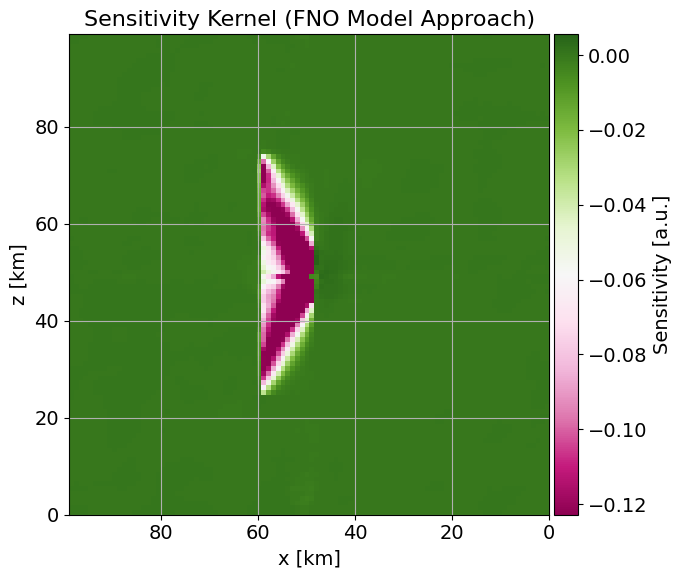

In [32]:
fig, ax = plt.subplots()
im = ax.imshow(kernel.plot(), extent=[z[-1], z[0], x[0], x[-1] ], aspect='equal', cmap=plt.get_cmap("PiYG"), vmin=kernel.min()*0.1, vmax=kernel.max())
ax = plt.gca()
ax.grid()
plt.xlabel(kernel.ax_info[0].l)
plt.ylabel(kernel.ax_info[1].l)
plt.title("Sensitivity Kernel (FNO Model Approach)")

cbar = plt.colorbar(im, orientation="vertical",
                    cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))
cbar.set_label('Sensitivity [a.u.]')
plt.tight_layout()
plt.show()
kernel_model = kernel.plot()

### Compare the Plots

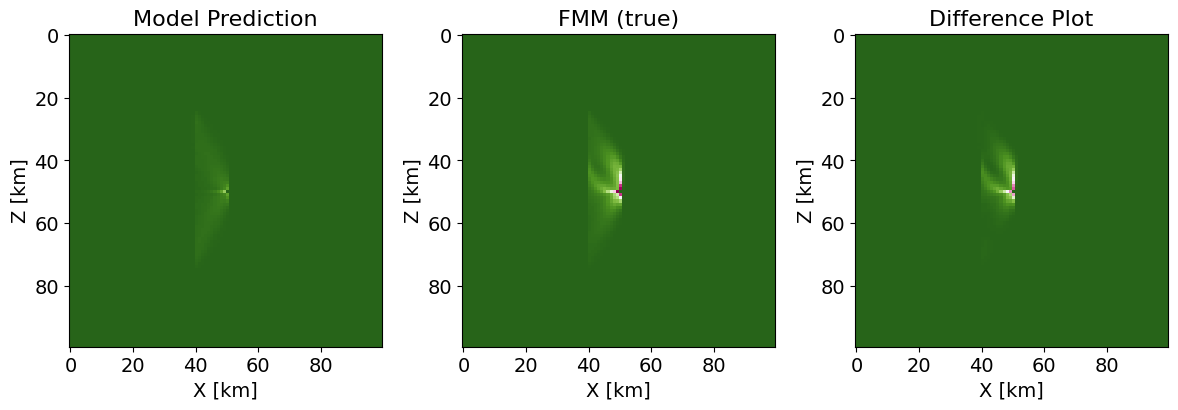

In [33]:
num_images = 3
plt.close()
plt.figure(figsize=(12,4))

diff1 = - abs(kernel_fmm - kernel_model)
images = [img for img in [kernel_model, kernel_fmm, diff1]]
labels = ["Model Prediction", "FMM (true)", "Difference Plot"]


scale_min = np.min([np.min(x) for x in images])
scale_max = np.max([np.max(x) for x in images])

for i, (img, label) in enumerate(zip(images, labels)):
    plt.subplot(1, num_images, i+1)
    plt.imshow(img, vmin=scale_min, vmax=scale_max, cmap='PiYG', aspect='equal')
    plt.xlabel("X [km]")
    plt.ylabel("Z [km]")
    plt.title(label)

plt.tight_layout()

# Remove the following line to make all plots the same, but remove the colorbar
# plt.colorbar()

plt.show()